# Gaussian Processes Regression and Classification

COMP4670/8600 - Statistical Machine Learning - Tutorial

In this lab, we will focus on Gaussian process regression and classification techniques.

### Assumed knowledge
- Multivariate Gaussians: joint, marginal and conditional distributions. Refer to Chapter 2, Section 2.3 of Bishop for some important formulae.
- Kernels and the kernel trick
- Two views of supervised learning: parameter space and function space
- Applying kernels to Bayesian regression and classification

### After this lab, you should be comfortable with
- Implementing GP regression and classification

Setting up the environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

%matplotlib inline

## Getting Used to Multivariate Gaussians

### Gaussian distribution

The pdf of a random variable $x \in \mathbb{R}^d$ following a normal distribution with mean $\mu \in \mathbb{R}^d$ and covariance matrix $\Sigma \in \mathbb{R}^{d \times d}$ is

$$
\begin{align*}
\mathcal{N}(x \mid \mu, \Sigma) = \frac{1}{(2 \pi)^{d/2}} \frac{1}{\lvert \Sigma \rvert^{1/2}} \exp \left\{ -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right\}.
\end{align*}
$$

**Q1.** Implement the below function for the multivariate Gaussian pdf.

In [2]:
def multivariate_normal(x, mean, cov):
    """
    PDF of the multivariate normal distribution.
    Args:
        x: example, of shape (d, )
        mean: mu, of shape (d,)
        cov: Sigma, of shape (d, d)
    Returns:
        A scalar
    """
    # Check if dimensions match
    d = x.shape[0]
    assert x.shape == (d,), f"x is not of shape ({d},)"
    assert mean.shape == (d,), f"Mean vector is not of shape ({d},)"
    assert cov.shape == (d,d), f"Cov matrix vector is not of shape ({d}, {d})"
    
    # ADD YOUR SOLUTION HERE
    x_m = x - mean
    return (1. / ((2 * np.pi) ** (d / 2))) * \
           (1. / ((np.linalg.det(cov)) ** (1/2))) * \
           np.exp(- (1/2) * (np.linalg.solve(cov, x_m).T.dot(x_m)))

In [3]:
# Test your function's correctness
np.random.seed(100)
d = 2  # Number of dimensions
mean = np.array([1, 0])
cov = np.array([[1, -0.7],
                [-0.7, 1]])
x = np.array([1, 2])

pdf_x_implemented = multivariate_normal(x, mean, cov)
print(f"[YOUR    METHOD] p(x) = {pdf_x_implemented:.10f}")

pdf_x_scipy = scipy.stats.multivariate_normal(mean=mean, cov=cov).pdf(x)
print(f"[SCIPY's METHOD] p(x) = {pdf_x_scipy:.10f}")

print("MATCH?", np.allclose(pdf_x_implemented, pdf_x_scipy))

[YOUR    METHOD] p(x) = 0.0044148853
[SCIPY's METHOD] p(x) = 0.0044148853
MATCH? True


#### Plot the Gaussian PDF

In [4]:
def generate_pdf_data(mean, cov):
    d = mean.shape[0]
    
    N = 50
    x1s = np.linspace(mean[0]-3, mean[0]+3, num=N)
    x2s = np.linspace(mean[1]-3, mean[1]+3, num=N)
    x1, x2 = np.meshgrid(x1s, x2s)
    pdf = np.zeros((N, N))
    
    for i in range(N):
        for j in range(N):
            pdf[i,j] = multivariate_normal(
                np.array([x1[i,j], x2[i,j]]), 
                mean, cov)
    return x1, x2, pdf

def plot_gaussian_pdf(mean, cov, ax):
    x1, x2, p = generate_pdf_data(mean, cov)
    cb = ax.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
    ax.set_xlabel('$x_1$', fontsize=13)
    ax.set_ylabel('$x_2$', fontsize=13)
    ax.set_aspect('equal')

    # cbar = plt.colorbar(cb)
    # cbar.ax.set_ylabel('$PDF$', fontsize=13)

    # Show the mean
    ax.scatter(mean[0], mean[1], marker="x", color="red", s=60, label="Mean")

    ax.legend()

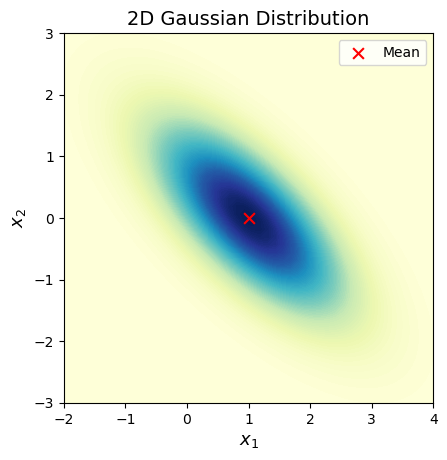

In [5]:
from matplotlib import cm

# SETTING UP THE DISTRIBUTION
np.random.seed(100)
d = 2  # Number of dimensions
mean = np.array([1, 0])
cov = np.array([[1, -0.7],
                [-0.7, 1]])

# PLOT THE PDF
fig, ax = plt.subplots(1, 1)
plot_gaussian_pdf(mean, cov, ax)
ax.set_title('2D Gaussian Distribution', fontsize=14)
plt.show()

### Marginal distributions
Suppose that a Gaussian random variable $x$ contains two components as follows

$$
\begin{align*}
    \mathcal{N}(x \mid \mu, \Sigma) = 
    \mathcal{N}
    \left(
        \left.
        \begin{bmatrix}
        x_a \\
        x_b
        \end{bmatrix}
        \right|
        \begin{bmatrix}
        \mu_a \\
        \mu_b
        \end{bmatrix},
        \begin{bmatrix}
        \Sigma_{aa} & \Sigma_{ab} \\
        \Sigma_{ba} & \Sigma_{bb}
        \end{bmatrix}
    \right),
\end{align*}
$$

where $x_a \in \mathbb{R}^{m}$ and $x_b \in \mathbb{R}^{d-m}$.

Your job is to find $p(x_a)$ and $p(x_b)$.

**Q2.** What are the parameters (i.e., mean and covariance) of the marginal distributions of $x_a$ and $x_b$?

#### Solution

$x_a$ follows a Gaussian distribution with mean $\mu_a$ and covariance $\Sigma_{aa}$ (eqs. 2.92--2.93 in Bishop). Similar for $x_b$.

#### Plot marginal distributions

In the below example, we assume that $x \in \mathbb{R}^{2}$, $x_a = x_1 \in \mathbb{R}$ and $x_b = x_2 \in \mathbb{R}$.

**Q3.** Fill the the blanks in the following code blocks to finish plotting the marginal distributions for $x_a$ and $x_b$.

In [6]:
def univariate_normal(x, mean, var):
    """
    PDF of the univariate normal distribution.
    Args:
        x: example, scalar
        mean: mu, scalar
        var: Sigma, scalar
    Returns:
        A scalar
    """
    return ((1. / np.sqrt(2 * np.pi * var)) * 
            np.exp(-(x - mean)**2 / (2 * var)))

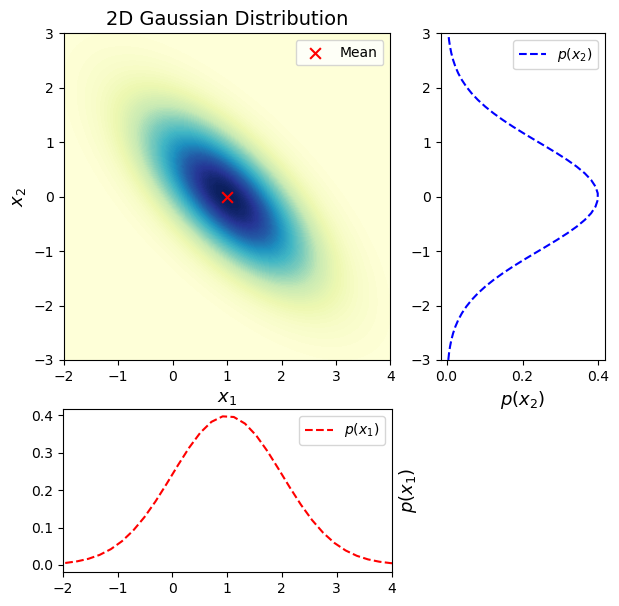

In [7]:
from matplotlib import gridspec
np.random.seed(100)
d = 2  # Number of dimensions
mean = np.array([1, 0])
cov = np.array([[1, -0.7],
                [-0.7, 1]])
m_a, m_b = mean
s_aa, s_ab, s_ba, s_bb = cov.flatten()

fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[2, 1])

# Plot the joint distribution p(xa, xb)
ax = plt.subplot(gs[0])
plot_gaussian_pdf(mean, cov, ax)
ax.set_title('2D Gaussian Distribution', fontsize=14)

# Plot the marginal distribution p(x1)
# FIND THE MEAN AND VARIANCE OF x1
mean_xa = mean[0]
var_xa = cov[0, 0]
ax = plt.subplot(gs[2])
x = np.linspace(-5, 5, num=50)
px = univariate_normal(x, mean_xa, var_xa)
# Plot univariate distribution
ax.plot(x, px, 'r--', label="$p(x_1)$")
ax.legend(loc=0)
ax.set_ylabel("$p(x_1)$", fontsize=13)
ax.yaxis.set_label_position('right')
ax.set_xlim(-2, 4)

# Plot the marginal distribution p(x2)
# FIND THE MEAN AND VARIANCE OF x2
mean_xb = mean[1]
var_xb = cov[1, 1]
ax = plt.subplot(gs[1])
x = np.linspace(-3, 3, num=50)
px = univariate_normal(x, mean_xb, var_xb)
# Plot univariate distribution
ax.plot(px, x, 'b--', label="$p(x_2)$")
ax.legend(loc=0)
ax.set_xlabel('$p(x_2)$', fontsize=13)
ax.yaxis.set_label_position('right')
ax.set_ylim(-3, 3)

plt.show()

### Conditional Distributions
Here we continue to assume a Gaussian random variable $x$ contains two components as follows

$$
\begin{align*}
    \mathcal{N}(x \mid \mu, \Sigma) = 
    \mathcal{N}
    \left(
        \left.
        \begin{bmatrix}
            x_a \\
            x_b
        \end{bmatrix}
        \right|
        \begin{bmatrix}
            \mu_a \\
            \mu_b
        \end{bmatrix},
        \begin{bmatrix}
            \Sigma_{aa} & \Sigma_{ab} \\
            \Sigma_{ba} & \Sigma_{bb}
        \end{bmatrix}
    \right),
\end{align*}
$$
where $x_a \in \mathbb{R}^{m}$ and $x_b \in \mathbb{R}^{d-m}$.

Your job is to find $p(x_a \mid x_b)$ and $p(x_b \mid x_a)$.

**Q4.** Find the parameters (i.e., mean and covariance) for the conditional distributions $p(x_a \mid x_b)$ and $p(x_b \mid x_a)$.

#### Solution

Both $x_a \mid x_b$ and $x_b \mid x_a$ are Gaussian random variables. For $p(x_a \mid x_b)$, we have

$$
\begin{align*}
\mu_{a \mid b} &= \mu_a + \Sigma_{ab} \Sigma_{bb}^{-1}(x_b - \mu_b), \\
\Sigma_{a \mid b} &= \Sigma_{aa} - \Sigma_{ab} \Sigma_{bb}^{-1} \Sigma_{ba}.
\end{align*}
$$

(Eqs. 2.81--2.82 in Bishop)

Similarly, for $p(x_b \mid x_a)$, we have

$$
\begin{align*}
\mu_{b \mid a} &= \mu_b + \Sigma_{ba} \Sigma_{aa}^{-1}(x_a - \mu_a), \\
\Sigma_{b \mid a} &= \Sigma_{bb} - \Sigma_{ba} \Sigma_{aa}^{-1} \Sigma_{ab}.
\end{align*}
$$

#### Plot conditional distributions

In the below example, we assume that $x \in \mathbb{R}^{2}$, $x_a = x_1 \in \mathbb{R}$ and $x_b = x_2 \in \mathbb{R}$. In this case, all matrix inverse becomes scalar inverse when finding the paramters of the conditional distributions. 

**Q5.** Fill the the blanks in the following code blocks to finish plotting the conditional distributions for $x_a \mid x_b$ and $x_b \mid x_a$.

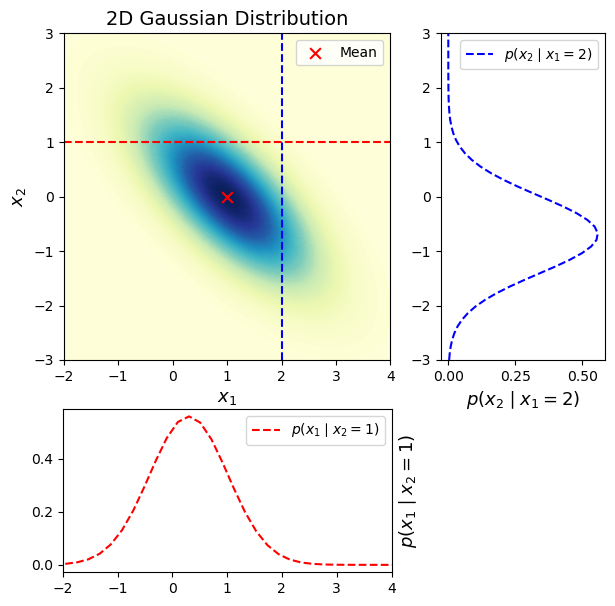

In [8]:
from matplotlib import gridspec
# SETTING UP THE DISTRIBUTION
np.random.seed(100)
d = 2  # Number of dimensions
mean = np.array([1, 0])
cov = np.array([[1, -0.7],
                [-0.7, 1]])
m_a, m_b = mean
s_aa, s_ab, s_ba, s_bb = cov.flatten()

fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[2, 1])

# Plot the joint distribution p(xa, xb)
ax = plt.subplot(gs[0])
plot_gaussian_pdf(mean, cov, ax)
ax.set_title('2D Gaussian Distribution', fontsize=14)
ax.plot([-2, 4], [1, 1], "r--")
ax.plot([2, 2], [-3, 3], "b--")

# Plot the marginal distribution p(xa | xb)
# FIND THE MEAN AND VARIANCE OF xa | xb, when xb = 1
x_b = 1
mean_xa = m_a + s_ab * (1/s_bb) * (x_b - m_b)
var_xa = s_aa - s_ab * (1/s_bb) * s_ba
ax = plt.subplot(gs[2])
x = np.linspace(-5, 5, num=50)
px = univariate_normal(x, mean_xa, var_xa)
# Plot univariate distribution
ax.plot(x, px, 'r--', label="$p(x_1 \mid x_2 = 1)$")
ax.legend(loc=0)
ax.set_ylabel("$p(x_1 \mid x_2 = 1)$", fontsize=13)
ax.yaxis.set_label_position('right')
ax.set_xlim(-2, 4)

# Plot the marginal distribution p(xb | xa)
# FIND THE MEAN AND VARIANCE OF xb | xa, when xa = 2
x_a = 2
mean_xb = m_b + s_ba * (1/s_aa) * (x_a - m_a)
var_xb = s_bb - s_ba * (1/s_aa) * s_ab
ax = plt.subplot(gs[1])
x = np.linspace(-3, 3, num=50)
px = univariate_normal(x, mean_xb, var_xb)
# Plot univariate distribution
ax.plot(px, x, 'b--', label="$p(x_2 \mid x_1 = 2)$")
ax.legend(loc=0)
ax.set_xlabel('$p(x_2 \mid x_1 = 2)$', fontsize=13)
ax.yaxis.set_label_position('right')
ax.set_ylim(-3, 3)

plt.show()

## Gaussian Process Regression

### Toy example

Let's work on a simple dataset of one dimension. 

Suppose the functional relationship between $x$ and $t$ is 

$$
y(x) = 0.08 x^{2} + 2 \sin\left(x\right) + 0.1 \tanh\left(x^{3}\right).
$$

In [9]:
def generate_regression_data(N=20):
    np.random.seed(42)
    X = np.linspace(-10, 10, N)
    t = 0.08 * X ** 2 + 2 * np.sin(X) + 0.1 * np.tanh(X ** 3)
    # Add Gaussian noise to t
    beta = 1000 # default no noise
    t += (1/np.sqrt(beta)) * np.random.randn(N)
    return np.expand_dims(X, 1), t

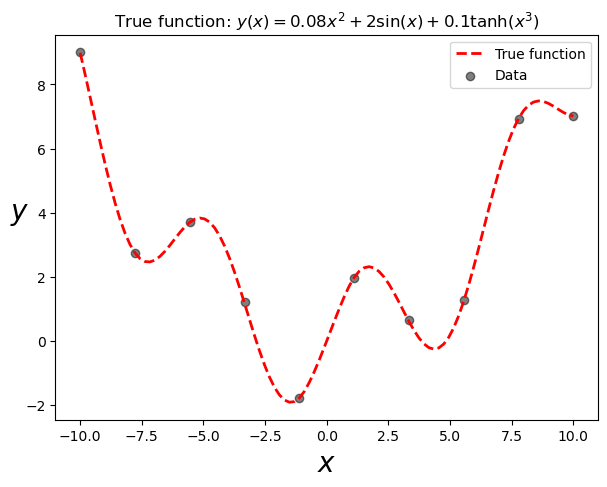

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Plot the true function
x_coords = np.linspace(-10, 10, 100)
true_function = 0.08 * x_coords ** 2 + 2 * np.sin(x_coords) \
                + 0.1 * np.tanh(x_coords ** 3)
ax.plot(x_coords.flatten(), true_function.flatten(), linewidth=2, color="r",
        linestyle="--", label="True function", alpha=1)

X, t = generate_regression_data(N=10)
ax.scatter(X.flatten(), t, c="k", alpha=0.5, label="Data")
ax.set_title("True function: $y(x) = 0.08 x^{2} + 2 \sin(x) + 0.1 \\tanh(x^{3})$")

ax.set_xlabel("$x$", size=20)
ax.set_ylabel("$y$", size=20, rotation=0)

ax.legend()
plt.show()

### The RBF Kernel

Given two examples $x_n$ and $x_m$, the radial basis function kernel on these two examples is defined as

$$
\begin{align*}
    k(x_n, x_m) = \exp \left\{ - \frac{\left\| x_n - x_m \right\|_2^2} {2 \sigma^2} \right\}
\end{align*},
$$
where $\left\| x_n - x_m \right\|_2^2$ is the squared Euclidean distance between $x_n$ and $x_m$, and $\sigma$ is a hyperparameter.

**Q5.** Implement the RBF kernel in the following function. You may find the `cdist` function in scipy useful.

In [11]:
def rbf(xa, xb, sigma=1):
    """
    RBF kernel.
    Args:
        xa: array of shape (N1, d)
        xb: array of shape (N2, d)
        sigma: non-zero scalar
    Returns:
        Kernel matrix of shape (N1, N2)
    """
    sqdist = scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(- sqdist / (2 * sigma ** 2))

### The Gaussian Process Regression Algorithm

**Q6.** Implement the algorithm for finding the mean and variance of $y^*$, as in Slide 41.

In [12]:
def gp_reg(x_star, X, t, kernel, beta, **kernel_kwargs):
    """
    Calculate the mean and variance for y_star.
    Args:
        x_star: new example, of shape (1, d)
        X: training exmaples, of shape (N, d)
        t: training targets, of shape (N,)
        kernel: kernel function
        beta: precision of the noise in the targets, scalar
        kernel_kwargs: any additional arguments for the kernel function
    Returns:
        mean of y_star
        variance of y_star
    """
    N, d = X.shape
    
    # Kernels
    K_X_X = kernel(X, X, **kernel_kwargs)
    K_X_X = K_X_X + (1/beta) * np.eye(N)  # Covariance of y (Bishop 6.82, GP book 2.20)
    
    K_x_star_X = kernel(x_star, X, **kernel_kwargs)
    
    K_x_star_x_star = kernel(x_star, x_star, **kernel_kwargs)
    
    # Use Cholesky decomposition
    L = np.linalg.cholesky(K_X_X)
    
    # Find alpha (solution to K alpha = t)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, t))
    
    # Find mean of y_star
    m_x_star = K_x_star_X @ alpha
    
    # Find variance of y_star
    v = np.linalg.solve(L, K_x_star_X.T)
    variance_x_star = K_x_star_x_star - v.T @ v
    
    return m_x_star.flatten()[0], variance_x_star.flatten()[0]

#### Plot the predictions

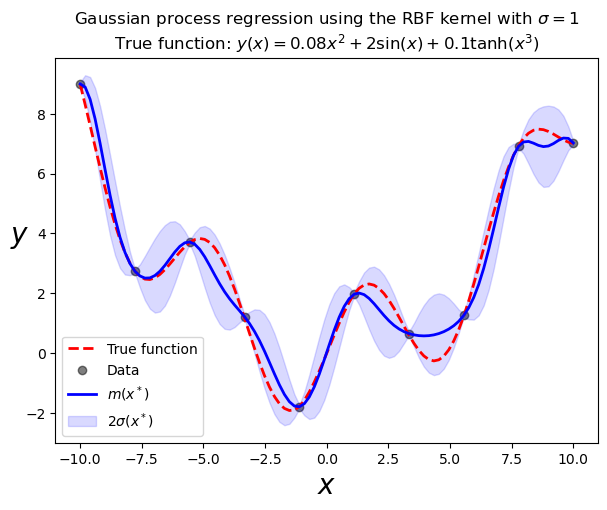

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Plot the true function
x_coords = np.linspace(-10, 10, 100)
true_function = 0.08 * x_coords ** 2 + 2 * np.sin(x_coords) \
                + 0.1 * np.tanh(x_coords ** 3)
ax.plot(x_coords.flatten(), true_function.flatten(), linewidth=2, color="r",
        linestyle="--", label="True function", alpha=1)

# Plot data points
ax.scatter(X.flatten(), t, c="k", alpha=0.5, label="Data")

# Plot the predicted mean and stddev
x_coords = np.linspace(-10, 10, 100)
x_coords = np.expand_dims(x_coords, 1)
predicted = [gp_reg(np.expand_dims(x, 1), 
                    X=X, 
                    t=t, 
                    beta=1000,  # This needs fine-tuning, see later
                    kernel=rbf,
                    **{"sigma": 1}  # This also needs fine-tuning
                    ) 
             for x in x_coords]
predicted_m = np.array([m for m, v in predicted])
predicted_stddev = np.array([np.sqrt(v) for m, v in predicted])

ax.plot(x_coords.flatten(), predicted_m, 'b-', lw=2, 
         label='$m(x^*)$')
ax.fill_between(x_coords.flatten(), 
                predicted_m-2*predicted_stddev, 
                predicted_m+2*predicted_stddev, 
                color='blue', 
                alpha=0.15, label='$2 \sigma(x^*)$')

ax.set_title("Gaussian process regression" + 
             f" using the RBF kernel with $\sigma = {1}$" +
             "\n" +
             "True function: $y(x) = 0.08 x^{2} + 2 \sin(x) + 0.1 \\tanh(x^{3})$"
             )
ax.set_xlabel("$x$", size=20)
ax.set_ylabel("$y$", size=20, rotation=0)

ax.legend()
plt.show()

### Tuning hyperparameters

The RBF kernel has one hyperparameter, $\sigma$, often referred to as the "width". Here, we will aim to find the "best" $\sigma$ for our dataset using grid search.

**Q7.** Write out the log likelihood of the data in terms of the kernel matrix. What quantities are affected by the kernel's hyperparameter $\sigma$?

#### Solution

Let
- $N$ be the number of training examples.
- $K \in \mathbb{R}^{N \times N}$ be the kernel matrix where $K_{i,j} = k(x_i, x_j)$ for all $x_i$, $x_j$ in the training set.
- $L \in \mathbb{R}^{N \times N}$ be the result of Cholesky decomposition of $K$, such that $K = L L^T$.
- $\alpha = L^T \backslash (L \backslash t) \in \mathbb{R}^{N}$. In other words, $\alpha$ is the solution to $LL^T \alpha = t$.

Then, the log likelihood is

$$
\begin{align*}
\ln p(t \mid X) &= - \frac{1}{2} \ln \lvert K \rvert - \frac{1}{2} t^T K^{-1} t - \frac{N}{2} \ln(2\pi) \\
&= - \sum_{i=1}^{N} \ln(L_{ii}) - \frac{1}{2} t^T \alpha - \frac{N}{2} \ln(2\pi).
\end{align*}
$$

On the right-hand side, the first two quantities are affected by the kernel's hyperparameters. The last quantity is just a constant.

**Q8.** Complete the following code blocks to calculate the log likelihood for each value of $\sigma$ in the RBF kernel. Comment on your final choice of $\sigma$ that best fits this dataset.

In [14]:
def log_likelihood(X, t, kernel, beta, **kernel_kwargs):
    """
    Calculate the data log likelihood.
    Args:
        X: training exmaples, of shape (N, d)
        t: training targets, of shape (N,)
        kernel: kernel function
        beta: precision of the noise in the targets, scalar
        kernel_kwargs: any additional arguments for the kernel function
    Returns:
        A scalar
    """
    N, d = X.shape
    K_X_X = kernel(X, X, **kernel_kwargs) + (1/beta) * np.eye(N)
    L = np.linalg.cholesky(K_X_X)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, t))
    
    # IMPLEMENT THIS
    loglik = - np.sum(np.log(np.diag(L))) - 0.5 * np.dot(t, alpha) - (N / 2) * np.log(2 * np.pi)
    
    return loglik

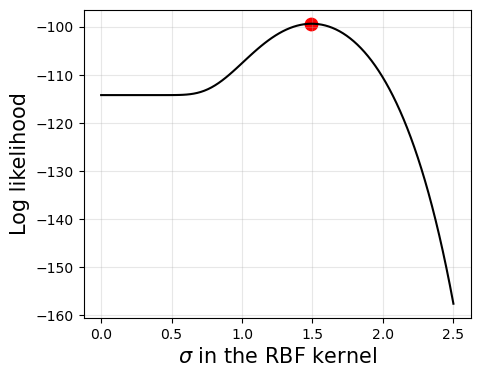

The best value for sigma (when beta is fixed at 1000) is 1.489939393939394


In [15]:
# Define a set of values for sigma
sigma_range = np.linspace(0.0001, 2.5, 100)

# Fix beta
beta = 1000

# For each sigma, find the log likelihood
logliks = []
for sigma in sigma_range:
    logliks.append(log_likelihood(X, t, rbf, beta, **{"sigma": sigma}))

# Plot the log likelihood against sigma
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(sigma_range, logliks, color="black")
ax.set_xlabel("$\sigma$ in the RBF kernel", size=15)
ax.set_ylabel("Log likelihood", size=15)

# Denote the value with the highest log likelihood
best_idx = np.argmax(logliks)
best_sigma = sigma_range[best_idx]
best_loglik = logliks[best_idx]
ax.scatter([best_sigma], [best_loglik], color="red", s=80)
ax.grid(alpha=0.3)
plt.show()

# Print the best hyperparameter
print(f"The best value for sigma (when beta is fixed at {beta}) is", best_sigma)

**Q9.** Another hyperparameter is $\beta$, the precision of the additive noise on the targets. In practice, you will need to find the combination of both $\beta$ and $\sigma$ that best fit this dataset.

Extend the code above to accommodate the grid search over both $\beta$ and $\sigma$.

### Using another kernel

**Q10.** Pick a kernel function of your choice; e.g., the polynomial kernel. Then write a function similar to `rbf` above and use the `gp_reg` function to find the distribution of the targets.

If you kernel has hyperparameters, such as $\sigma$ for the RBF kernel, choose some example values and examine the final plot. You will need to use the `**kernel_kwargs` in this case.

## Gaussian Process Classification

### Toy example

Let's work on a binary classification setting.

Suppose the true decision boundary is

$$
3x^{2}+3y^{3}-2y^{2}-4xy-0.5x^{2}y-2=0.
$$

In [16]:
def sigmoid(a):
    return scipy.special.expit(a)
def true_fn(x, y, binary=True):
    a = 3 * x ** 2 + 3 * y ** 3 - 2 * y ** 2 - 4 * x * y - 0.5 * x ** 2 * y - 2 
    if not binary:
        return a
    else:
        return (a > 0).astype(int)

In [17]:
def generate_classification_data(N=20):
    np.random.seed(42)
    x1 = np.random.uniform(low=-3, high=3, size=N)
    x2 = np.random.uniform(low=-3, high=3, size=N)
    
    # Randomly flip some labels (noise)
    labels = true_fn(x1, x2, binary=False)
    labels = sigmoid(labels)
    labels_binary = np.array([np.random.binomial(1, p) for p in labels])
    
    return np.vstack([x1, x2]).T, labels_binary

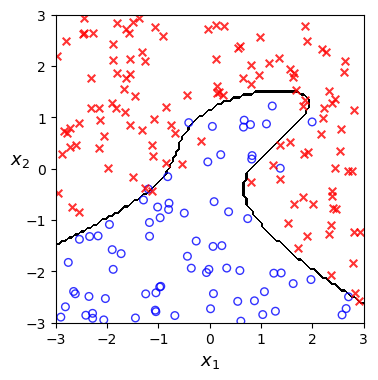

In [18]:
from matplotlib.colors import LinearSegmentedColormap

# Custom colormap
my_gradient = LinearSegmentedColormap.from_list('my_gradient', (
                 (0.000, (255, 255, 255)),
                 (0.100, (0, 0, 0)),
                 (0.500, (0, 0, 0)),
                 (0.900, (0, 0, 0)),
                 (1.000, (255, 255, 255))))

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# Plot decision boundary
N = 100
x1s = np.linspace(-3, 3, num=N)
x2s = np.linspace(-3, 3, num=N)
x1, x2 = np.meshgrid(x1s, x2s)
f = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        f[i,j] = true_fn(x1[i, j], x2[i, j])
cb = ax.contourf(x1, x2, f, cmap=my_gradient, alpha=1)
ax.set_xlabel('$x_1$', fontsize=13)
ax.set_ylabel('$x_2$', fontsize=13, rotation=0)
ax.set_aspect('equal')
ax.set_ylim([-3, 3])
ax.set_xlim([-3, 3])

# Plot the scatter points in the dataset
X, t = generate_classification_data(N=200)
ax.scatter(X[t==0, 0], X[t==0, 1], s=30, facecolors='none', 
            edgecolors='b', marker="o", alpha=0.8)
ax.scatter(X[t==1, 0], X[t==1, 1], s=30, marker="x", color="red", alpha=0.8)

plt.show()

### The Gaussian process classification algorithm

Here we will implement the Laplace approximation scheme described in the lecture.

#### Finding the MAP estimator $a_{\text{MAP}}$

Given the kernel matrix $K \in \mathbb{R}^{N \times N}$ and the target vector $t \in \mathbb{R}^{N}$, the mode of the distribution $p(a \mid X, t)$ satisfies

$$
a_{\text{MAP}} = K (t - \sigma(a_{\text{MAP}})).
$$

This is an implicit definiftion of $a_{\text{MAP}}$, as it appears on both sides of the equation. In general, a closed-form solution doesn't exist. Instead, we will try to approximate it using the fixed-point iteration.

**Q11.** Finish the following implementation of finding the fixed point to the above non-linear system. You may find the `scipy.optimize.fixed_point` function useful.

In [19]:
def f_a_map(a, K, t):
    """
    The right-hand side of the above equation.
    """
    return K @ (t - sigmoid(a))

def get_a_map(K, t): 
    return scipy.optimize.fixed_point(
        f_a_map, 
        x0=np.random.rand(200),  # random initial point
        args=(K, t),  # other arguments to f_a_map
        xtol=1e-03,
        maxiter=10000,
    )  

#### Implementing GP classification

**Q12.** Implement the procedure for finding the predictive distribution for Gaussian process classification (Slide 35).

In [20]:
def gp_classif(x_star, X, t, kernel, beta, **kernel_kwargs):
    """
    Calculate the mean and variance for y_star.
    Args:
        x_star: new example, of shape (1, d)
        X: training exmaples, of shape (N, d)
        t: training targets, of shape (N,)
        kernel: kernel function
        beta: precision of the noise in the targets, scalar
        kernel_kwargs: any additional arguments for the kernel function
    Returns:
        mean of y_star
        variance of y_star
    """
    N, d = X.shape
    
    # Kernels
    K_X_X = kernel(X, X, **kernel_kwargs)
    K_X_X = K_X_X + (1/beta) * np.eye(N)  # Covariance of y (Bishop 6.82, GP book 2.20)
    
    K_x_star_X = kernel(x_star, X, **kernel_kwargs)
    
    K_x_star_x_star = kernel(x_star, x_star, **kernel_kwargs)
    
    # Get the mode of p(a | X, t)
    a_map = get_a_map(K_X_X, t)
    
    # Calculate the parameters c and d^2
    c = K_x_star_X @ (t - sigmoid(a_map))
    d_sq = K_x_star_x_star.flatten()[0] - \
           K_x_star_X @ \
           np.linalg.inv(np.diag(1./(sigmoid(a_map) * (1 - sigmoid(a_map)))) +
                         K_X_X) @ \
           K_x_star_X.T
    
    return sigmoid(np.sqrt(1./(1 + np.pi * d_sq / 8)) * c).flatten()[0]

In [21]:
x_star = np.array([[0, -2]])
print("Example 1:", x_star)
print("Probability that example 1 is positive:", gp_classif(x_star, X, t, rbf, beta=1))

print()

x_star = np.array([[2.5, 2]])
print("Example 1:", x_star)
print("Probability that example 2 is positive:", gp_classif(x_star, X, t, rbf, beta=1))

Example 1: [[ 0 -2]]
Probability that example 1 is positive: 0.10068669640285018

Example 1: [[2.5 2. ]]
Probability that example 2 is positive: 0.8356394589661623


Note that $a_{\text{MAP}}$ only needs to be calculated once. Based on your code above, finish the following implementation for prediction of *multiple* examples.

In [22]:
def gp_classif_batch(X_star, X, t, kernel, beta, **kernel_kwargs):
    """
    X_star: new examples, of shape (M, d), where M is number of test examples
    """
    N, d = X.shape
    
    # Kernels
    K_X_X = kernel(X, X, **kernel_kwargs)
    K_X_X = K_X_X + (1/beta) * np.eye(N)

    
    # Get the mode of p(a | X, t)
    a_map = get_a_map(K_X_X, t)
    sigmoid_a_map = sigmoid(a_map)
        
    predicted_probs = []
    for x_star in X_star:
        x_star = np.expand_dims(x_star, 0)
        
        K_x_star_X = kernel(x_star, X, **kernel_kwargs)
        K_x_star_x_star = kernel(x_star, x_star, **kernel_kwargs)
        
        c = K_x_star_X @ (t - sigmoid(a_map))
        d_sq = K_x_star_x_star.flatten()[0] - \
               K_x_star_X @ \
               np.linalg.inv(
                   np.linalg.inv(np.diag(1./(sigmoid(a_map) * (1 - sigmoid(a_map))))) +
                   K_X_X) @ \
               K_x_star_X.T
        
        predicted_probs.append(sigmoid(np.sqrt(1./(1 + np.pi * d_sq / 8)) * c).flatten())
    
    return np.array(predicted_probs)

#### Plotting the predictions

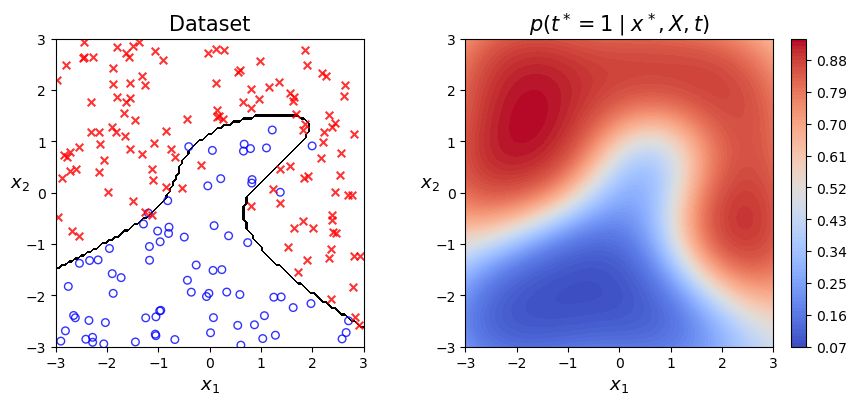

In [23]:
from tqdm import tqdm

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot decision boundary
ax = axes[0]
N = 100
x1s = np.linspace(-3, 3, num=N)
x2s = np.linspace(-3, 3, num=N)
x1, x2 = np.meshgrid(x1s, x2s)
f = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        f[i,j] = true_fn(x1[i, j], x2[i, j])
cb = ax.contourf(x1, x2, f, cmap=my_gradient, alpha=1)
ax.set_xlabel('$x_1$', fontsize=13)
ax.set_ylabel('$x_2$', fontsize=13, rotation=0)
ax.set_aspect('equal')
ax.set_ylim([-3, 3])
ax.set_xlim([-3, 3])

# Plot the scatter points in the dataset
X, t = generate_classification_data(N=200)
ax.scatter(X[t==0, 0], X[t==0, 1], s=30, facecolors='none', 
            edgecolors='b', marker="o", alpha=0.8)
ax.scatter(X[t==1, 0], X[t==1, 1], s=30, marker="x", color="red", alpha=0.8)

# Plot the predictions
N = 100
ax = axes[1]
x1s = np.linspace(-3, 3, num=N)
x2s = np.linspace(-3, 3, num=N)
x1, x2 = np.meshgrid(x1s, x2s)
X_star = np.zeros((N * N, 2))
for i in range(N):
    for j in range(N):
        X_star[i * N + j, 0] = x1[i, j]
        X_star[i * N + j, 1] = x2[i, j]
pred = gp_classif_batch(X_star, X, t, rbf, beta=1)
pred = pred.reshape(N, N)
cb = ax.contourf(x1, x2, pred, 100, cmap=cm.coolwarm, alpha=1)
cbar = plt.colorbar(cb, fraction=0.05)
# cbar.ax.shrink(0.8)

ax.set_xlabel('$x_1$', fontsize=13)
ax.set_ylabel('$x_2$', fontsize=13, rotation=0)
ax.set_aspect('equal')
ax.set_ylim([-3, 3])
ax.set_xlim([-3, 3])

axes[0].set_title("Dataset", size=15)
axes[1].set_title("$p(t^* = 1 \mid x^*, X, t)$", size=15)

plt.show()